In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from torch.profiler import profile, record_function, ProfilerActivity

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import time

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# DataLoader

In [5]:
class CustomDataset(Dataset):

    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.files_paths = [f for f in os.listdir(self.path) if f.endswith('.png')]
        self.data = [Image.open(os.path.join(self.path, f)).convert('RGB') for f in os.listdir(self.path) if f.endswith('.png')]
        self.labels = [f.split('-')[0] for f in self.files_paths]
        self.labels = [0 if x == 'horse' else 1 for x in self.labels]
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)
        # image = transforms.ToTensor()(image)
        # image = image.permute(1, 2, 0)
        return image, label

In [6]:

def get_normalization_values(path):
    """
    Compute the mean and standard deviation of the pixel values for each channel
    in the images stored in the specified folder.
    """
    red_values = []
    green_values = []
    blue_values = []

    for file in os.listdir(path):
        if file.endswith('.png'):
            image = Image.open(os.path.join(path, file))
            image_np = np.array(image)

            red, green, blue = image_np[:,:,0], image_np[:,:,1], image_np[:,:,2]

            red_values.append(red)
            green_values.append(green)
            blue_values.append(blue)

    red_mean = np.mean(red_values)/255
    green_mean = np.mean(green_values)/255
    blue_mean = np.mean(blue_values)/255

    red_std = np.std(red_values)/255
    green_std = np.std(green_values)/255
    blue_std = np.std(blue_values)/255

    return (red_mean, green_mean, blue_mean), (red_std, green_std, blue_std)


In [7]:
# mean, std = get_normalization_values("data/train/")

# mean = torch.tensor(mean)
# std = torch.tensor(std)


In [8]:
train_batch_size = 64
test_batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

train = CustomDataset(path = "data/train/",  transform=transform)
test = CustomDataset(path = "data/validation/", transform=transform)

train_loader = DataLoader(train, batch_size=train_batch_size, shuffle=True, pin_memory = True)
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=True, pin_memory = True)

In [7]:
# # Get the first batch of data from the data loader
# batch = next(iter(train_loader))
# data, labels = batch

# # Make a figure with subplots
# fig, axs = plt.subplots(8, 8, figsize=(8, 8))

# # Iterate over the data and labels and plot the images
# for i, (data, label) in enumerate(zip(data, labels)):
#     # Calculate the row and column indices for the subplot
#     data = np.squeeze(data)

#     row = i // 8
#     col = i % 8
#     # Plot the image on the corresponding subplot
#     ax = axs[row, col]
#     ax.imshow(data)
#     ax.axis('off')

# # Show the plot
# plt.show()

# Model Nostre

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Net_CNN(nn.Module):
    def __init__(self, channels, feature_size, num_classes):
        super().__init__()
        self.main = nn.Sequential(
            self.block(channels, feature_size, 3, 2, 1),
            self.block(feature_size, feature_size*2, 3, 2, 1),
            self.block(feature_size*2, feature_size*4, 3, 2, 1),
            self.block(feature_size*4, feature_size*8, 3, 2, 1),
            nn.Flatten(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(8, num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.main(x)

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

In [12]:
class Net_FCN(nn.Module):
    def __init__(self, channels, feature_size):
        super().__init__()
        self.main = nn.Sequential(
            self.block(channels, feature_size, 3, 2, 1), # 300x300 --> 150x150
            self.block(feature_size, feature_size*2, 3, 2, 1), # 150x150 --> 75x75
            self.block(feature_size*2, feature_size*4, 3, 2, 1), # 75x75 --> 38x38
            self.block(feature_size*4, feature_size*8, 3, 2, 1), # 38x38 --> 19x19
            self.block(feature_size*8, feature_size*4, 3, 2, 1), # 19x19 --> 10x10
            self.block(feature_size*4, feature_size*2, 3, 2, 1), # 10x10 --> 5x5
            self.block(feature_size*2, feature_size, 3, 2, 1), # 5x5 --> 3x3
            self.block(feature_size, 1, 3, 2, 0), # 3x3 --> 2x2
            nn.Flatten(),
            nn.Softmax(dim=1)
            
        )
    
    def forward(self, x):
        return self.main(x)

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

In [13]:
lr_CNN = 0.001
lr_FCN = 0.01

channels = 3

feature_size_CNN = 2
feature_size_FCN = 2

num_classes = 2

num_epochs_CNN = 50
num_epochs_FCN = 50

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        net_CNN = Net_CNN(channels, feature_size_CNN, num_classes).to(device)

net_FCN = Net_FCN(channels, feature_size_FCN).to(device)

net_CNN.apply(weights_init)
net_FCN.apply(weights_init)

criterion_CNN = nn.CrossEntropyLoss().to(device)
criterion_FCN = nn.CrossEntropyLoss().to(device)

optimizer_CNN = torch.optim.SGD(net_CNN.parameters(), lr=lr_CNN, momentum=0.9).to(device)
optimizer_FCN = torch.optim.SGD(net_FCN.parameters(), lr=lr_FCN, momentum=0.9).to(device)

torch.backends.cudnn.benchmark = True

In [14]:
print(prof.key_averages().table(sort_by="cpu_time_total"))


-------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            model_inference        39.90%       2.421ms        99.47%       6.035ms       6.035ms     420.000us        11.04%       3.792ms       3.792ms             1  
                                   aten::to         2.32%     141.000us        55.74%       3.382ms      93.944us     146.000us         3.84%       2.944ms      81.778us            36  
                             aten::_to_copy         4.43%     269.000

In [15]:
print(net_FCN)
pytorch_total_params_CNN = sum(p.numel() for p in net_CNN.parameters())
pytorch_total_params_FCN = sum(p.numel() for p in net_FCN.parameters())
print("Total number of parameters CNN: ", pytorch_total_params_CNN)
print("Total number of parameters FCN: ", pytorch_total_params_FCN)

Net_FCN(
  (main): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2)

In [16]:
start = time.time()

writer_train = SummaryWriter(f"logs/train")
writer_test = SummaryWriter(f"logs/test")

step_train = 0
step_test = 0

tr_loss = np.zeros((num_epochs_CNN))
te_loss = np.zeros((num_epochs_CNN))

tr_acc = np.zeros((num_epochs_CNN))
te_acc = np.zeros((num_epochs_CNN))

for epoch in range(num_epochs_CNN):

    train_loss = 0
    test_loss = 0
    train_acc = 0
    test_acc = 0

    net_CNN.train()
    for i, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = torch.tensor(labels)
        labels = labels.to(device)

        optimizer_CNN.zero_grad(set_to_none=True)
        outputs = net_CNN(data)
        loss = criterion_CNN(outputs, labels)
        loss.backward()
        optimizer_CNN.step()

        train_loss += loss.item()

        # compute the accuracy for this batch
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / len(labels)
        train_acc += accuracy


        writer_train.add_scalar("Training loss", loss, global_step=step_train)
        step_train += 1
    
    net_CNN.eval()
    with torch.no_grad():
        for j, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            labels = torch.tensor(labels)
            labels = labels.to(device)

            outputs = net_CNN(data)
            loss = criterion_CNN(outputs, labels)

            test_loss += loss.item()
            
            # compute the accuracy for this batch
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / len(labels)
            test_acc += accuracy

            writer_test.add_scalar("Test loss", loss, global_step=step_test)
            step_test += 1

    # compute the average loss and accuracy for each epoch
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_acc /= len(train_loader)
    test_acc /= len(test_loader)

    tr_loss[epoch] = train_loss
    te_loss[epoch] = test_loss
    tr_acc[epoch] = train_acc
    te_acc[epoch] = test_acc

    print(f"Epoch {epoch+1}/{num_epochs_CNN}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    
end = time.time()
print(end - start)

C:\Users\jonny\AppData\Local\Temp\ipykernel_308\229094773.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
C:\Users\jonny\AppData\Local\Temp\ipykernel_308\229094773.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Epoch 1/50, Train Loss: 0.7076, Test Loss: 0.6944, Train Acc: 0.4994, Test Acc: 0.5000
Epoch 2/50, Train Loss: 0.6734, Test Loss: 0.6937, Train Acc: 0.5594, Test Acc: 0.5000
Epoch 3/50, Train Loss: 0.6692, Test Loss: 0.6925, Train Acc: 0.5573, Test Acc: 0.5000
Epoch 4/50, Train Loss: 0.6445, Test Loss: 0.6874, Train Acc: 0.6060, Test Acc: 0.5938
Epoch 5/50, Train Loss: 0.6696, Test Loss: 0.6304, Train Acc: 0.5726, Test Acc: 0.5625
Epoch 6/50, Train Loss: 0.6216, Test Loss: 0.6169, Train Acc: 0.6811, Test Acc: 0.6641
Epoch 7/50, Train Loss: 0.6071, Test Loss: 0.5948, Train Acc: 0.6673, Test Acc: 0.6953
Epoch 8/50, Train Loss: 0.5778, Test Loss: 0.5504, Train Acc: 0.7414, Test Acc: 0.8320
Epoch 9/50, Train Loss: 0.5676, Test Loss: 0.5510, Train Acc: 0.7325, Test Acc: 0.8516
Epoch 10/50, Train Loss: 0.5441, Test Loss: 0.5327, Train Acc: 0.7858, Test Acc: 0.8242
Epoch 11/50, Train Loss: 0.5443, Test Loss: 0.5234, Train Acc: 0.8024, Test Acc: 0.8828
Epoch 12/50, Train Loss: 0.5325, Test Los

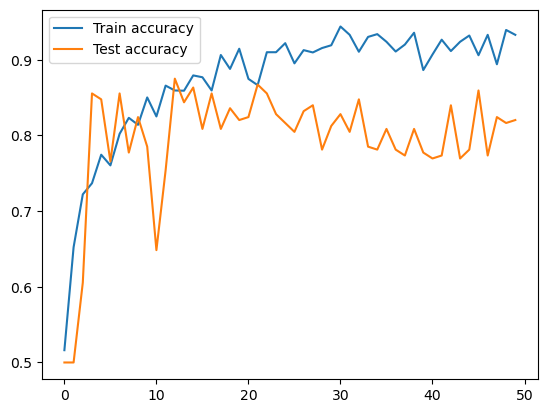

In [14]:
# plot the loss
plt.plot(tr_acc, label='Train accuracy')
plt.plot(te_acc, label='Test accuracy')
plt.legend()
plt.show()

In [15]:
step_test = 0

tr_loss = np.zeros((num_epochs_FCN))
te_loss = np.zeros((num_epochs_FCN))

tr_acc = np.zeros((num_epochs_FCN))
te_acc = np.zeros((num_epochs_FCN))

for epoch in range(num_epochs_FCN):

    train_loss = 0
    test_loss = 0
    train_acc = 0
    test_acc = 0

    net_FCN.train()
    for i, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), torch.tensor(labels).to(device)

        optimizer_FCN.zero_grad(set_to_none=True)
        outputs = net_FCN(data)
    
        labels = labels.unsqueeze(1)
        print(outputs, labels)

        loss = F.binary_cross_entropy(outputs,  labels.type(torch.float32))
        loss.backward()
        optimizer_FCN.step()

        train_loss += loss.item()

        # compute the accuracy for this batch
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / len(labels)
        train_acc += accuracy

    net_FCN.eval()
    with torch.no_grad():
        for j, (data, labels) in enumerate(test_loader):
            data, labels = data.to(device), torch.tensor(labels).to(device)

            optimizer_FCN.zero_grad(set_to_none=True)
            outputs = net_FCN(data)
        
            labels = labels.unsqueeze(1)
            loss = F.binary_cross_entropy(outputs,  labels.type(torch.float32))

            test_loss += loss.item()

            # compute the accuracy for this batch
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / len(labels)
            test_acc += accuracy

    # compute the average loss and accuracy for each epoch
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_acc /= len(train_loader)
    test_acc /= len(test_loader)

    tr_loss[epoch] = train_loss
    te_loss[epoch] = test_loss
    tr_acc[epoch] = train_acc
    te_acc[epoch] = test_acc

    print(f"Epoch {epoch+1}/{num_epochs_FCN}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

C:\Users\walli\AppData\Local\Temp\ipykernel_16500\914054602.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = data.to(device), torch.tensor(labels).to(device)


tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>) tensor([[0],
        [1],
        [0],
        [0],
      

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>) tensor([[0],
        [1],
        [1],
        [0],
      

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>) tensor([[1],
        [1],
        [0],
        [0],
      

C:\Users\walli\AppData\Local\Temp\ipykernel_16500\914054602.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = data.to(device), torch.tensor(labels).to(device)


Epoch 1/50, Train Loss: 49.6936, Test Loss: 50.0000, Train Acc: 29.4118, Test Acc: 32.0000
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>) tensor([[1],
        [0],
        [0],
        [1],
      

KeyboardInterrupt: 

In [ ]:
# plot the loss
plt.plot(tr_acc, label='Train accuracy')
plt.plot(te_acc, label='Test accuracy')
plt.legend()
plt.show()

# Model Existent

https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/

In [28]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


In [29]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./data/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [30]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [31]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [32]:
def init_model(num_classes, feature_extract, weights=None):
    model = resnet50(weights=weights)
    set_parameter_requires_grad(model, feature_extract)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    input_size = 224
    return model, input_size

In [33]:
model, input_size = init_model(num_classes, feature_extract)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 